In [233]:
import sys
import numpy as np
sys.path.append('../..')
from lib.tree_ensemble_training.german_rf import get_model
from lib.tree_extractor import path_extractor
clf, (X_train, y_train, X_test, y_test, data_table), dataset, model, parameters = get_model()
paths = path_extractor(clf, 'random forest', (X_train, y_train))

target = 'credit_risk'
X = data_table.drop(target, axis=1).values
y = data_table[target].values
from lib.tree_extractor import assign_samples
assign_samples(paths, (X, y))

features = data_table.columns[1:]
new_feature = {}
feature_pos = {}
for index, feature in enumerate(features):
    if ' - ' in feature:
        name, p = feature.split(' - ')
        p = int(p)
        if name not in new_feature:
            new_feature[name] = []
        while p >= len(new_feature[name]):
            new_feature[name].append(-1)
        new_feature[name][p] = index
    else:
        new_feature[feature] = [index]

feature_range = {}
for key in new_feature:
    if key in data_table.columns:
        feature_range[key] = [data_table[key].min(), data_table[key].max() + 1]
    else:
        feature_range[key] = [0, len(new_feature[key])]
    for i, j in enumerate(new_feature[key]):
        feature_pos[j] = (key, i)

for index, path in enumerate(paths):
    path['index'] = index

paths = [path for path in paths if np.sum(path['sample']) > 0]

mat = np.array([p['sample'] for p in paths]).astype('float')

for i, path in enumerate(paths):
    sum = np.sqrt(np.sum(mat[i]))
    if sum > 0:
        mat[i] /= sum

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [406]:
feature_range

{'status': [1, 5],
 'duration': [4, 73],
 'amount': [250, 18425],
 'savings': [1, 6],
 'employment_duration': [1, 6],
 'installment_rate': [1, 5],
 'personal_status_sex': [0, 2],
 'present_residence': [1, 5],
 'age': [19, 76],
 'credit_history': [0, 5],
 'purpose': [0, 11],
 'other_debtors': [0, 3],
 'property': [0, 4],
 'other_installment_plans': [0, 3],
 'housing': [0, 3],
 'job': [0, 4],
 'people_liable': [0, 2],
 'telephone': [0, 2],
 'foreign_worker': [0, 2],
 'number_credits': [0, 4]}

In [440]:
categorical_data = ['foreign_worker', 'savings', 'personal_status_sex', 'credit_history', 'purpose', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'people_liable', 'telephone', 'foreign_worker', 'number_credits']

suffix_sum = []
for i in range(X.shape[1]):
    sum = np.zeros(X[:, i].max() + 2)
    for val in X[:, i]:
        sum[val] += 1
    for i in range(1, len(sum)):
        sum[i] += sum[i - 1]
    suffix_sum.append(sum)

def check_path(path):
    m = path['range']
    cover = np.ones(len(X))
    for key in m:
        name = feature_pos[key][0]
        if name in categorical_data:
            cover = cover * (X[:, int(key)] >= m[key][0]) * (X[:, int(key)] < m[key][1])
        else:
            cond = [int(max(feature_range[name][0], m[key][0])), int(min(feature_range[name][1], m[key][1]))]
            sum = suffix_sum[int(key)]
            center_count = sum[cond[1]] - sum[cond[0] - 1]
            remain_count = len(X) - center_count
            for i in range(len(cover)):
                dist = 0
                if X[i, int(key)] < cond[0]:
                    dist = (sum[cond[0] - 1] - sum[X[i, int(key)] - 1]) / remain_count
                elif X[i, int(key)] > cond[1]:
                    dist = (sum[X[i, int(key)] - 1] - sum[cond[1]]) / remain_count
                cover[i] *= (1 - dist)
    return cover

In [436]:
cover = check_path(paths[0])

[4, 12] 9 0
[250, 922] 2799 0.549171270718232
[1, 3] 2 0


In [460]:
print(mat.sum(axis = 1).mean())
print(mat2.sum(axis = 1).mean())

68.71190635838664
20.701790704895974


In [441]:
mat = np.array([check_path(p) for p in paths]).astype('float')


In [429]:
interpret_path(paths[0])

([('savings', 'is', 'unknown/no savings account'),
  ('property', 'is not', 'unknown / no property'),
  ('purpose', 'is not', 'furniture/equipment'),
  ('duration', '<=', 12),
  ('amount', '<=', 922),
  ('present_residence', 'is not', '>= 7 yrs')],
 'accept')

In [203]:
sys.path.append('../..')
from lib.data_encoding import german_credit_encoding

output_labels = ['reject', 'accept']
current_encoding = german_credit_encoding

def interpret_path(path):
    conds = {}
    for k in path['range']:
        name = feature_pos[k][0]
        val = path['range'][k]
        if name in current_encoding:
            if name not in conds:
                conds[name] = [1] * len(current_encoding[name])
            if name in data_table.columns:
                for i in range(feature_range[name][0], feature_range[name][1]):
                    if i < val[0] or i > val[1]:
                        conds[name][i - feature_range[name][0]] = 0
            else:
                if val[0] > 0:
                    conds[name] = [0] * len(current_encoding[name])
                    conds[name][feature_pos[k][1]] = 1
                else:
                    conds[name][feature_pos[k][1]] = 0
        else:
            cond = [max(feature_range[name][0], val[0]), min(feature_range[name][1], val[1])]
            conds[name] = cond

    output_conds = []
    for name in conds:
        val = conds[name]
        op = 'is'
        value = ''
        if name in current_encoding:
            is_negation = np.sum(val) * 2 >= len(val) and len(val) > 2
            if is_negation:
                op = 'is not'
                for i, d in enumerate(val):
                    if d == 0:
                        value = value + ' and ' + current_encoding[name][i]
                value = value[5:]
            else:
                for i, d in enumerate(val):
                    if d == 1:
                        value = value + ' or ' + current_encoding[name][i]
                value = value[4:]
        else:
            if val[0] == feature_range[name][0]:
                op = '<='
                value = int(val[1])
            elif val[1] == feature_range[name][1]:
                op = '>='
                value = int(val[0])
            else:
                op = 'in'
                value = '%d to %d' % (int(val[0]), int(val[1]))
        output_conds.append((name, op, value))
    output_label = output_labels[path['output']]
    # print(output_labels, path['output'])
    # print(conds)
    return output_conds, output_label

In [3]:

import matplotlib.pyplot as plt
x_tsne = np.load('path_tsne.npy')

In [527]:
from sklearn.metrics import pairwise_distances

import numpy as np
import math

from typing import Union


def run_loci(data: np.ndarray, alpha: float = 0.5, k: int = 3):
    """Run the LOCI algorithm on the specified dataset.
    Runs the LOCI algorithm for the specified datset with the specified
    parameters, returns a LOCI object, from which outlier indices can
    be accessed via the indice property.
    Parameters
    ----------
    data: np.ndarray
        Shape - [number of datapoints, number of dimensions]
    alpha: float, optional
        Default is 0.5 as per the paper. See the paper for full details.
    k: int, optional
        Default is 3 as per the paper. See the paper for full details.
    """
    loci_i = LOCIMatrix(data, alpha, k)
    loci_i.run()
    return loci_i



class LOCIMatrix():
    """
    data: np.ndarray
    alpha: float, optional
    k: int, optional
    See the loci function for more details on the parameters.
    Attributes
    ----------
    _data: np.ndarray
    _alpha: float
    _k: int
    max_dist: float
    n_points: int
    indice: np.ndarray
    _dist_matrix: np.ndarray
        The distance matrix, has shape [n_data_points, n_data_points]
    """

    def __init__(self, data: np.ndarray, alpha: float = 0.85, k: int = 3):
        self.data = data
        self.alpha = alpha
        self.k = k

        self.max_dist = None
        self.n_points = self.data.shape[0]
        self.indice = None
        self.dist_matrix = pairwise_distances(X = self.data, metric='cosine')
        self.sorted_neighbors = np.argsort(self.dist_matrix, axis=1)
        self.sorted_dist = np.sort(self.dist_matrix, axis=1)
        self.outer_ptr = np.zeros(self.n_points).astype(int)
        self.inner_ptr = np.zeros(self.n_points).astype(int)

    def update_outer_pointer(self, r):
        ptr = self.outer_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def update_inner_pointer(self, r):
        ptr = self.inner_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def run(self):
        """Executes the LOCI algorithm"""
        self.result = []
        for p_ix in range(self.n_points):
            self.result.append({
                'records': [],
            })
        sqrt_n = int(math.sqrt(self.n_points))
        r_max = self.sorted_dist[:, sqrt_n].max() / self.alpha
        r_min = self.sorted_dist[:, 10].min()
        self.rs = []
        self.scores = [[] for _ in range(self.n_points)]
        print('r range: %.3f - %.3f, alpha: %.3f' % (r_min, r_max, self.alpha))

        n_steps = 250
        for i in range(n_steps):
            r = i / n_steps * (r_max - r_min) + r_min
            self.rs.append(r)
            self.update_outer_pointer(r)
            self.update_inner_pointer(self.alpha * r)
            for p_ix in range(self.n_points):
                neighbors = self._get_sampling_N(p_ix)
                n_values = self._get_alpha_n(neighbors)
                cur_alpha_n = self._get_alpha_n(p_ix)

                n_hat = np.mean(n_values)
                mdef = 1 - (cur_alpha_n / n_hat)
                sigma_mdef = np.std(n_values) / n_hat
                self.result[p_ix]['records'].append((r, mdef, sigma_mdef))

                score = 0
                if len(neighbors) >= 20:
                    if sigma_mdef > 0:
                        score = mdef / sigma_mdef
                self.scores[p_ix].append(score)

        step = (r_max - r_min) / n_steps
        r = self.sorted_dist[:, int(math.sqrt(self.n_points))].mean()
        self.indice = np.array([int((self.sorted_dist[i, sqrt_n] - r_min) / step) for i in range(self.n_points)])
        self.min_indice = np.array([np.argmin(self.scores[i]) for i in range(self.n_points)])
        self.max_indice = np.array([np.argmax(self.scores[i]) for i in range(self.n_points)])
        self.scores = np.array(self.scores)
        self.outlier_score = np.array([self.scores[i, self.indice[i]] for i in range(self.n_points)])
        return True

    def label_propagation(self, x, label, thres = 0.10):
        conf = {}
        visit = {}
        conf[x] = 1
        Q = [x]
        head = 0
        while head < len(Q):
            x = Q[head]
            head += 1
            if x in visit:
                continue
            visit[x] = 1
            
            if label == 0:
                new_indice = self.min_indice[x]
            else:
                new_indice = self.max_indice[x]
            self.indice[x] = self.indice[x] * conf[x] + new_indice * (1 - conf[x])
            for i, j in enumerate(self.sorted_neighbors[x]):
                sim = (1 - self.sorted_dist[x, i]) * conf[x]
                if sim < thres:
                    break
                conf[j] = conf.get(j, 0) + sim
                Q.append(j)

    def _get_sampling_N(self, p_ix: int):
        return self.sorted_neighbors[p_ix][:self.outer_ptr[p_ix]]

    def _get_alpha_n(self, indices: Union[int, np.ndarray]):
        return self.inner_ptr[indices]



In [528]:
res = run_loci(mat_fuzzy)

r range: 0.137 - 1.720, alpha: 0.500


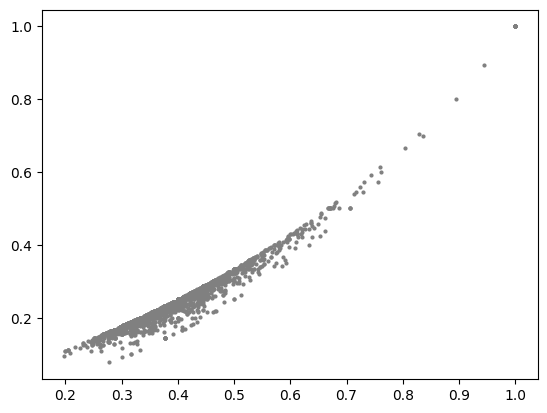

In [389]:

vec = []
for x in range(100):
    for i, j in enumerate(res.sorted_neighbors[x, :20]):
        cos_sim = 1 - res.sorted_dist[x, i]
        iou_sim = np.sum(mat[x] * mat[j] > 0) / len(np.flatnonzero(np.array(paths[x]['sample']) + np.array(paths[j]['sample'])))
        vec.append([cos_sim, iou_sim])
vec = np.array(vec)

plt.scatter(vec[:, 0], vec[:, 1], s = 4, color='gray')
plt.show()
    

In [84]:
np.quantile(res.sorted_dist[:, :98], 0.2)

0.6533123773592318

In [145]:
anomaly = res.sorted_dist[:, 20].argsort()
print(len(anomaly))

9661


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [65]:
int(math.sqrt(res.n_points))

98

In [58]:
for i in [4657, 7567, 7845, 3400, 6290]:
    print(interpret_path(paths[i]))

([('employment_duration', 'is not', 'unemployed and < 1 yr'), ('credit_history', 'is', 'no credits taken/all credits paid back duly'), ('housing', 'is', 'own'), ('duration', '>=', 11), ('status', 'is not', '... >= 200 DM (salary)'), ('other_installment_plans', 'is', 'none'), ('job', 'is', 'skilled employee / official'), ('other_debtors', 'is not', 'none')], 'accept')
([('employment_duration', 'is not', 'unemployed and < 1 yr'), ('purpose', 'is', 'furniture/equipment'), ('housing', 'is not', 'rent'), ('installment_rate', 'is not', '< 20 and 20 to 25'), ('property', 'is', 'real estate'), ('present_residence', 'is not', '>= 7 yrs')], 'accept')
([('housing', 'is', 'own'), ('employment_duration', 'is not', 'unemployed and < 1 yr'), ('telephone', 'is', 'No'), ('purpose', 'is not', 'others and car (used)'), ('credit_history', 'is', 'no credits taken/all credits paid back duly'), ('amount', '<=', 3565), ('duration', '<=', 8)], 'accept')
([('credit_history', 'is', 'existing credits paid back du

In [29]:
order = res.outlier_score.argsort()
order_score = res.outlier_score[order]
rank = [0 for i in range(res.n_points)]
for i, j in enumerate(order):
    rank[j] = i
xs = [i for i in range(res.n_points)]
xs = np.array(xs)
deeprules = [i for i in range(res.n_points) if len(interpret_path(paths[i])[0]) > 9]

In [100]:
res.sorted_dist[:, 98].mean()

0.7764802800670986

In [32]:

mat = np.array([p['sample'] for p in paths]).astype('float')
samples = mat.sum(axis = 1)


In [229]:
for i in res.sorted_neighbors[9501][1:5]:
    print(i, interpret_path(paths[i]))

4117 ([('duration', '>=', 15), ('purpose', 'is not', 'car (used)'), ('property', 'is not', 'unknown / no property'), ('amount', '<=', 1077)], 'accept')
6382 ([('duration', '>=', 15), ('status', 'is not', '... >= 200 DM (salary)'), ('number_credits', 'is not', '2 to 3'), ('other_installment_plans', 'is', 'none'), ('amount', '<=', 1077)], 'reject')
6250 ([('duration', '>=', 15), ('property', 'is', 'car or other'), ('housing', 'is not', 'rent'), ('credit_history', 'is not', 'delay in paying off in the past'), ('people_liable', 'is', '0 to 2'), ('amount', '<=', 1370)], 'reject')
9404 ([('other_installment_plans', 'is', 'none'), ('credit_history', 'is not', 'all credits at this bank paid back duly'), ('purpose', 'is not', 'furniture/equipment'), ('telephone', 'is', 'No'), ('housing', 'is not', 'rent'), ('job', 'is not', 'skilled employee / official'), ('amount', '<=', 1263)], 'accept')


In [201]:
outliers

array([6511, 1723, 4185,  616,  668, 7483, 8019, 1072, 6515, 9501, 1939,
       2009, 1888, 8020, 6801, 2819, 3319, 4626, 4251, 1516, 5003, 5258,
       4117, 1238, 9626, 8618, 6668, 9536, 2882, 7878, 5979, 8087, 4381,
       8235, 6455, 9345,   44, 2742, 5639, 8018, 2181, 8415, 9531, 7804,
       3486, 6491, 2915, 4759, 1324, 6494])

In [94]:
outliers = res.scores[:, 210].argsort()[-50:]

In [385]:
idx = 9626
for it, i in enumerate(res.sorted_neighbors[idx][:5]):
    r = interpret_path(paths[i])
    print('IF ' + ' AND '.join([str(t[0]) + ' ' + str(t[1]) + ' ' + str(t[2]) for t in r[0]]) + ' THEN ' + r[1])
    print(paths[i]['confidence'], res.sorted_dist[idx, it])

IF credit_history is no credits taken/all credits paid back duly AND savings is unknown/no savings account or < 100 DM AND purpose is not furniture/equipment AND people_liable is 0 to 2 AND employment_duration is 4 to 7 yrs or >= 7 yrs AND duration >= 22 AND age <= 37 THEN reject
0.5714285714285714 0.0
IF credit_history is no credits taken/all credits paid back duly AND installment_rate is not < 20 and 20 to 25 AND age <= 46 AND telephone is No AND housing is not own AND duration >= 15 AND employment_duration is 4 to 7 yrs or >= 7 yrs THEN reject
0.6923076923076923 0.701857603000028
IF credit_history is no credits taken/all credits paid back duly AND other_debtors is not guarantor AND telephone is No AND duration >= 21 AND savings is not >= 1000 DM AND employment_duration is 4 to 7 yrs or >= 7 yrs AND present_residence is >= 7 yrs THEN accept
0.6666666666666666 0.7038255611204538
IF savings is not 500 to 1000 DM and >= 1000 DM AND duration >= 12 AND status is not 0 to 200 DM and ... >=

[8611, 9546, 8610, 6897, 8110, 11, 1207, 3367, 6774]


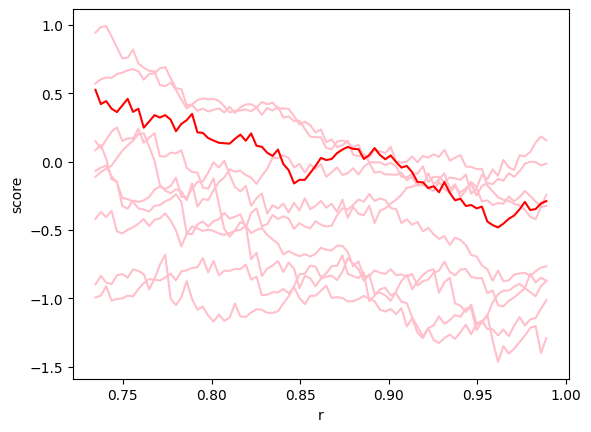

In [379]:
fig, ax = plt.subplots()
fp = [1734]# 6801, 5258, 9626]
fp_neighbors = []
for i in fp:
    for j in range(1, 10):
        if res.sorted_dist[i, j] < 0.62:
            fp_neighbors.append(res.sorted_neighbors[i, j])

print(fp_neighbors)
for x in fp_neighbors:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][160:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][160:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][160:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='pink')

for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][160:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][160:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][160:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='red')
ax.set_xlabel('r')
ax.set_ylabel('score')
#  ax.legend()
plt.show()

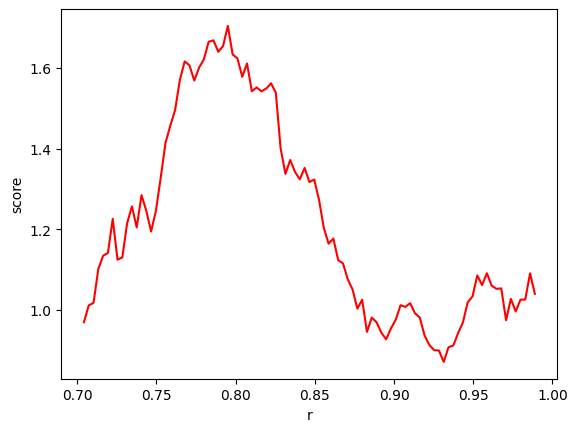

In [249]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in []:#tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in [4234]:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='r')
normal = [1,2,3,4,5,6,7,8,9,10]
for x in []:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='pink')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: Runt

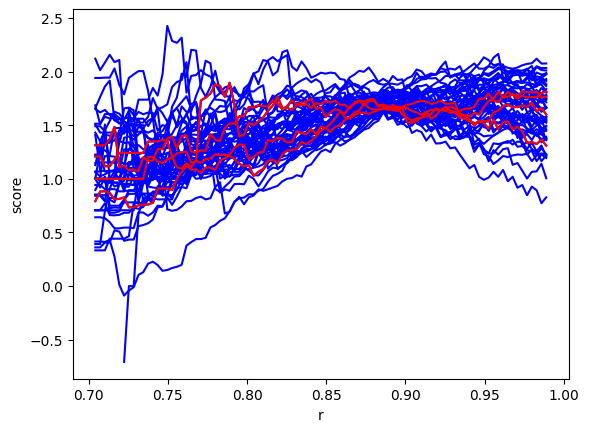

In [137]:
fig, ax = plt.subplots()
tp = outliers
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
fp = [9501, 6801, 5258, 9626]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='r')
ax.set_xlabel('r')
ax.set_ylabel('score')
#  ax.legend()
plt.show()

In [484]:
res.outlier_score = res.scores.max(axis = 1)

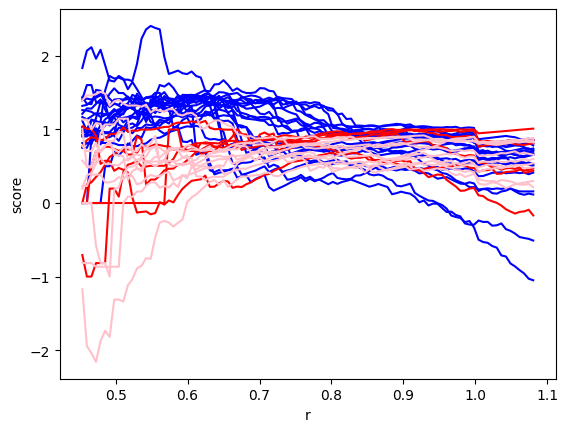

In [530]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-100]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-100]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-100]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-100]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-100]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-100]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='r')
normal = [1,2,3,4,5,6,7,8,9,50]
for x in normal:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-100]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-100]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-100]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='pink')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

In [507]:
res.outlier_score[tp]

array([15.15131062, 15.19260514, 15.40251894, 15.55049097, 15.59178549,
       15.75524296, 15.76384598, 15.80686111, 15.90493559, 15.92558285,
       15.96859797, 15.97548039, 16.00128947, 16.03742217, 16.0460252 ,
       16.06495185, 16.13893786, 16.21292388, 16.24733598, 16.27314505])

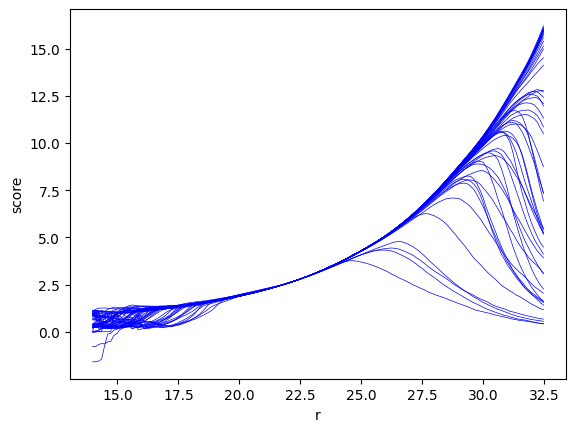

In [512]:
res.outlier_score = res.scores[:, 150]
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-50:]
for x in tp:
    ranks = []
    ax.plot(res.rs[100:], res.scores[x, 100:], linewidth=0.5, color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

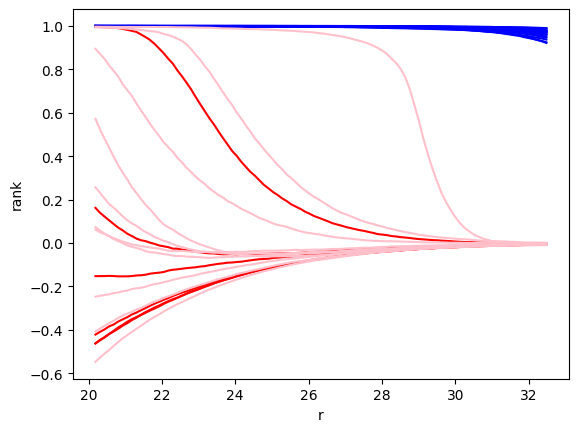

In [503]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs, label=str(x) + ' score', color='r')
normal = [i for i in range(100, 200, 10)]
for x in normal:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs, label=str(x) + ' score', color='pink')
ax.set_xlabel('r')
ax.set_ylabel('rank')
#  ax.legend()
plt.show()

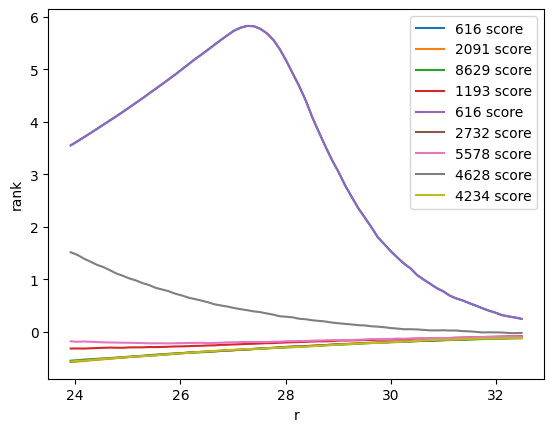

In [505]:
fig, ax = plt.subplots()
fp = [616, 2091, 8629, 1193, 616, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][180:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][180:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][180:]])
    # for i in range(180, res.scores.shape[1]):
    #     rank = np.sum(res.scores[:, i] > res.scores[x, i])
    #     ranks.append(rank)
    # print(xs, ranks)
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score')
    # ax.plot(xs, mdefs, label=str(x) + ' MDEF')
    # ax.plot(xs, s_mdefs, label=str(x) + ' S_MDEF')
ax.set_xlabel('r')
ax.set_ylabel('rank')
#ax.set_yscale('log')
ax.legend()
plt.show()

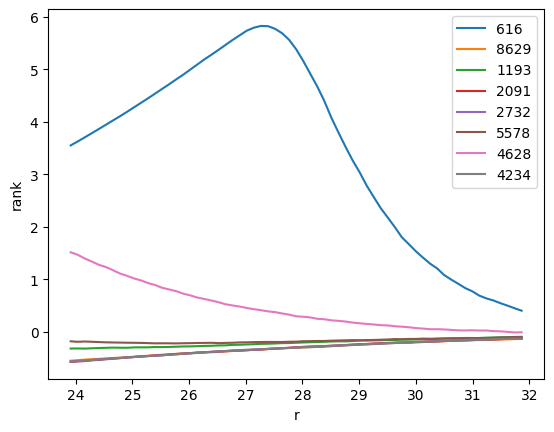

In [506]:
fig, ax = plt.subplots()
fp = [616, 8629, 1193, 2091, 2732, 5578, 4628, 4234]
#fp = [1,2,4,5,6]
for x in fp:
    ranks = []
    xs = res.rs[180:-5]
    for i in range(180, res.scores.shape[1] - 5):
        rank = res.scores[x, i]
        ranks.append(rank)
    # print(xs, ranks)
    ax.plot(xs, ranks, label=str(x))
ax.set_xlabel('r')
ax.set_ylabel('rank')
#ax.set_yscale('log')
ax.legend()
plt.show()

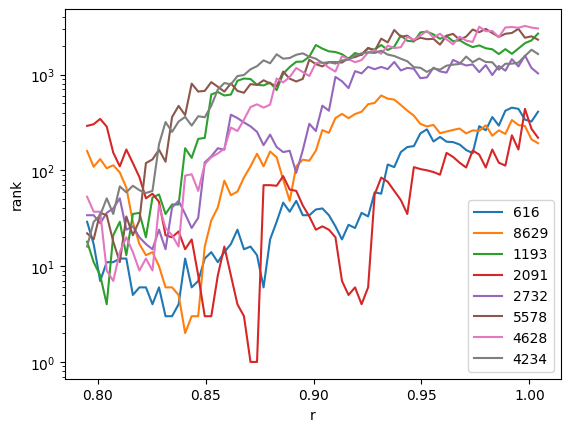

In [70]:
fig, ax = plt.subplots()
fp = [616, 8629, 1193, 2091, 2732, 5578, 4628, 4234]
# fp = [1,2,4,5,6,7]
for x in fp:
    ranks = []
    xs = res.rs[180:]
    for i in range(180, res.scores.shape[1]):
        rank = np.sum(res.scores[:, i] > res.scores[x, i])
        ranks.append(rank)
    # print(xs, ranks)
    ax.plot(xs, ranks, label=str(x))
ax.set_xlabel('r')
ax.set_ylabel('rank')
ax.set_yscale('log')
ax.legend()
plt.show()

1.9097504922133661 -5.822781955308944 0.306308256367816


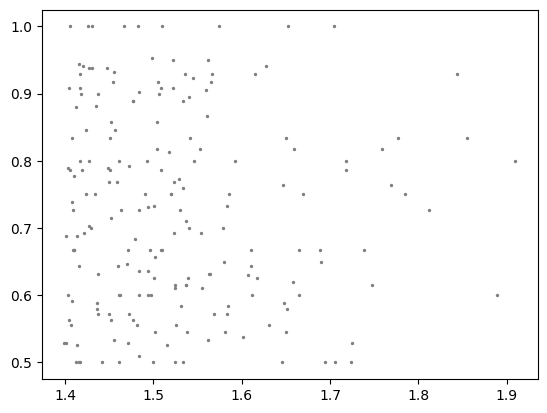

In [212]:
score = res.scores[:, 180]
anomaly = score.argsort()[-200:]
print(score.max(), score.min(), score.mean())
conf = np.array([p['confidence'] for p in paths])
plt.scatter(score[anomaly], conf[anomaly], s = 2, color='gray')
plt.show()

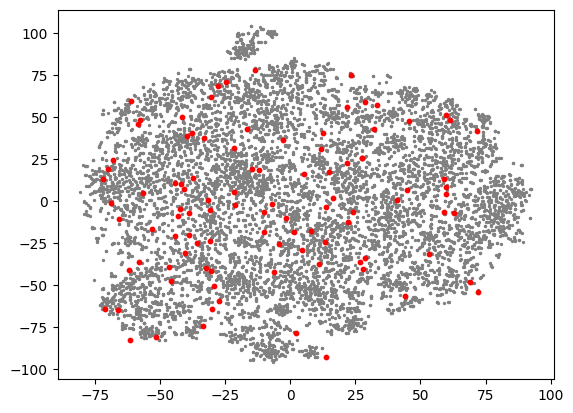

In [45]:
step = (res.rs[1] - res.rs[0])
r_min = res.rs[0]
sqrt_n = int(math.sqrt(res.n_points))
res.outlier_indices = [int((res.sorted_dist[i, sqrt_n] - r_min) / step) for i in range(res.n_points)]
res.scores = np.array(res.scores)
#res.outlier_score = np.array([res.scores[i, res.outlier_indices[i]] for i in range(res.n_points)])
res.outlier_score = np.array([res.scores[i, int((res.sorted_dist[i, sqrt_n] - r_min) / step)] for i in range(res.n_points)])

anomaly = res.outlier_score.argsort()[-100:][::-1]
#print(anomaly)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 10, color='red')
plt.show()

In [127]:

anomaly = 
#print(anomaly)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 10, color='red')
plt.show()

1.1354041026140427

In [29]:
x_sample_tsne = x_tsne[:500]

In [42]:
print(res.sorted_dist[anomaly2, 20].mean())
print(res.sorted_dist[:500, 20].mean())
print(res.sorted_dist[res.sorted_dist[:500, 20].argsort()[-5:], 20])

0.6871191895786511
0.6664664251176068
[0.77207885 0.77354459 0.7807355  0.78995799 0.80635083]


In [143]:
res.outlier_score[res.outlier_score.argsort()[::-1][300]]

1.3645458988908608

In [61]:
non_anomaly = np.flatnonzero(res.outlier_score < 1)

In [20]:
np.argmin(res.scores[1647][180:])

47

In [66]:
for it, i in enumerate(res.sorted_neighbors[9185][:20]):
    print(i, res.outlier_score[i], 1 - res.sorted_dist[9185, it])

9185 0.3757191739064244 1.0
4134 -0.05918258675369054 0.5577733510227172
3773 0.598619501510504 0.5179323973782373
8462 -0.29178030029391455 0.5041183773141629
4249 -0.7843166184503516 0.46947647786157076
678 0.06289839382456602 0.46409548089225705
532 -0.7512068250736634 0.42761798705987897
2071 0.505833578347433 0.41576092031015
6108 0.4397910242557188 0.4057411124598246
827 0.75821759683563 0.40118870990143896
5228 0.32654607151571646 0.39440531887330765
1454 0.2597734977241268 0.3795360576382949
2118 0.5963679247390012 0.3766588923446066
7971 0.31615101624178793 0.3733393086486333
1919 0.6474377020916215 0.3688555567816587
2668 0.45879286514007867 0.3646464492724877
4049 1.015637482434589 0.3603749850782235
1555 -0.4542745733053593 0.358568582800318
3573 0.485900047401699 0.34914862437758787
9240 0.15899858743818493 0.3490050304482666


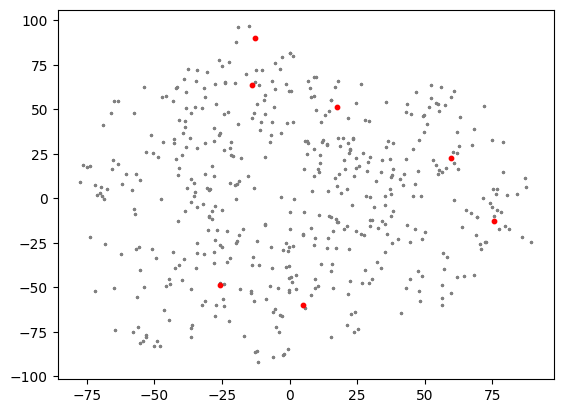

In [103]:

anomaly = res.outlier_score.argsort()[-100:][::-1]
anomaly2 = [i for i in anomaly if i < 500]
anomaly3 = res.sorted_dist[:500, 20].argsort()[-5:]
plt.scatter(x_sample_tsne[:, 0], x_sample_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_sample_tsne[anomaly2, 0], x_sample_tsne[anomaly2, 1], s = 10, color='red')
plt.show()

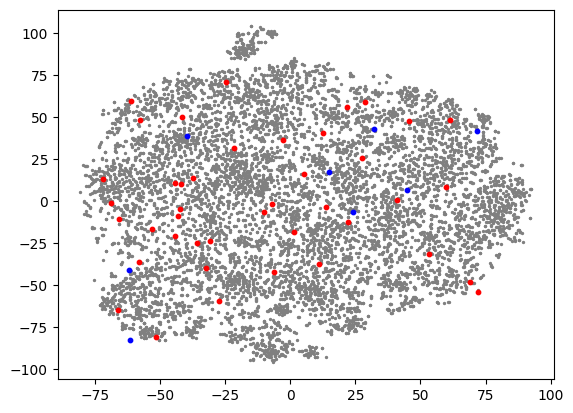

In [133]:
label = '11110110111110111111111101111111110101110111011111'
anomaly = anomaly[:50]
tp = [j for i, j in enumerate(anomaly) if label[i] == '1']
fp = [j for i, j in enumerate(anomaly) if label[i] == '0']
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[tp, 0], x_tsne[tp, 1], s = 10, color='red')
plt.scatter(x_tsne[fp, 0], x_tsne[fp, 1], s = 10, color='blue')
plt.show()

In [55]:
(res.scores[:, 240] > res.scores[3485, 240]).sum()

49

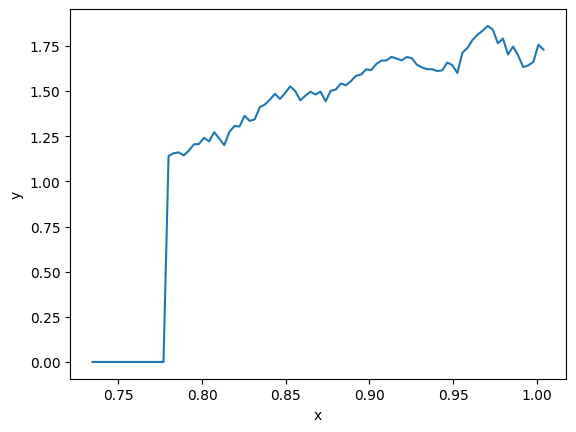

In [52]:

import pandas as pd
import seaborn as sns

linedata = pd.DataFrame({
    'y': [res.scores[3485, k] for k in range(160, len(res.rs), 1)],
    'x': [res.rs[k] for k in range(160, len(res.rs), 1)],
}, columns=['x', 'y'])
sns.lineplot(x="x",
             y="y",
             data=linedata)

plt.show()


In [57]:
res.rs[res.outlier_indices[616]]

0.834443079104808

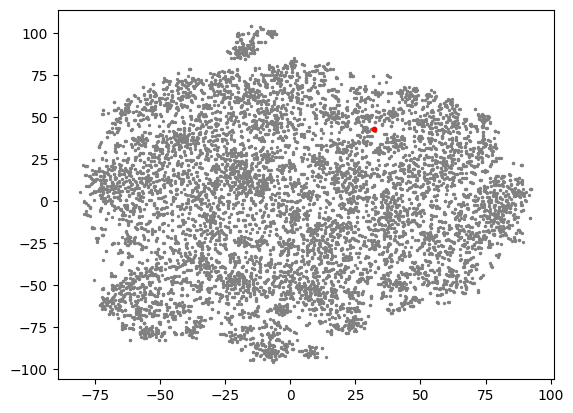

In [113]:
anomaly = res.outlier_score.argsort()[-50:][::-1]
#print(anomaly)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[[4234], 0], x_tsne[[4234], 1], s = 10, color='red')
plt.show()

In [7]:
for i in [2]:
    print(interpret_path(paths[i]))

([('savings', 'is', 'unknown/no savings account'), ('property', 'is not', 'unknown / no property'), ('purpose', 'is not', 'furniture/equipment'), ('duration', '<=', 12), ('amount', '>=', 922), ('number_credits', 'is not', '2 to 3'), ('telephone', 'is', 'Yes')], 'accept')


In [93]:
res.outlier_score[res.outlier_score.argsort()[-50:][::-1]]

array([1.81242375, 1.80767886, 1.78966401, 1.78953929, 1.75713243,
       1.75381015, 1.74771078, 1.74419956, 1.73731884, 1.72148037,
       1.71714098, 1.71123606, 1.70971684, 1.70914067, 1.70600345,
       1.70223887, 1.70124351, 1.68483128, 1.67844404, 1.67501449,
       1.66953475, 1.66201002, 1.66092075, 1.65959516, 1.65830554,
       1.65525755, 1.65409493, 1.65127661, 1.64876369, 1.63927103,
       1.63272569, 1.62806504, 1.62184761, 1.62162829, 1.62085559,
       1.62084007, 1.61991311, 1.61649677, 1.61141477, 1.61048634,
       1.60719362, 1.60626457, 1.60532553, 1.60356745, 1.59290624,
       1.58735158, 1.58558786, 1.58345326, 1.58029894, 1.57993553])

In [522]:
res.rs[100]

13.97800630607065

In [526]:
rules = []
class_count = {}
all_labels = {}
max_n_conds = 0
top_n = 200
filtered_id = {}
count = 0
res.outlier_score = res.scores[:, 80]
outliers = res.outlier_score.argsort()[-50:][::-1]
idxes = outliers
anomalies = 0
for it, i in enumerate(idxes):
    conds, output = interpret_path(paths[i])
    class_count[output] = class_count.get(output, 0) + 1
    if i in all_labels:
        if all_labels[i] == '1':
            anomalies += 1
        j = it + 1
        if j == 10 or j == 20 or j == 50:
            print('precision@%d: %.2f' % (j, anomalies / j))
    label = all_labels.get(i, -1)
    count += 1
    rules.append({'cond': conds, 'predict': output, 'index': i, 'order': it, 'attr': 0, 'labels': int(label) })
    max_n_conds = max(len(conds), max_n_conds)
conds_per_line = 4
max_n_conds = math.ceil(max_n_conds / conds_per_line) * conds_per_line

f = open('loci_0705.csv', 'w')

for it, rule in enumerate(rules):
    s = '' + str(rule['order'])
    line = 0
    n_conds = len(rule['cond'])
    n_lines = math.ceil(n_conds / conds_per_line)
    index = rule['index']

    for line in range(n_lines):
        if line == 0:
            s += ',#%d,IF,' % (index)
        else:
            s += ',,,'
        for pos in range(conds_per_line):
            i = pos + line * conds_per_line
            if i < n_conds:
                item = rule['cond'][i]
                s += item[0] + ',' + item[1] + ',' + str(item[2]) + ','
                s += 'AND,' if i < n_conds - 1 else '...,'
            else:
                s += '...,...,...,...,'
        if line == n_lines - 1:
            s = s[:-4]
            s += 'THEN,%s,%d,%3f' % (rule['predict'], np.sum(paths[index]['distribution']), paths[index]['confidence'])
        s += '\n'
    f.write(s + '\n')
f.close()

In [252]:
all_

{7305: 1, 8624: 0, 1884: 1, 468: 1, 6290: 0, 8055: 0, 2280: 1, 3400: 1, 4466: 0, 4650: 0, 6028: 1, 4459: 1, 1411: 1, 665: 0, 868: 1, 8911: 1, 3848: 0, 9283: 0, 5218: 0, 3035: 0, 1010: 1, 8934: 1, 6483: 1, 2807: 1, 5767: 1, 1763: 1, 4479: 1, 679: 1, 873: 1, 6641: 1, 178: 0, 2278: 1, 7567: 0, 287: 1, 7527: 1, 6569: 1, 3487: 1, 2363: 1, 1750: 0, 2300: 1, 6277: 0, 8240: 1, 7499: 1, 525: 0, 4785: 0, 9324: 0, 3337: 1, 3617: 1, 5003: 1, 2089: 1, 3204: 1, 991: 1, 2167: 1, 3488: 1, 1507: 1, 1840: 1, 4932: 1, 254: 1, 9096: 1, 5974: 0, 7529: 1, 2764: 1, 9134: 1, 2112: 0, 7845: 0, 8073: 1, 4657: 0, 3270: 1, 5502: 1, 616: 1, 6787: 0, 6801: 1, 3486: 1, 405: 1, 3485: 1, 8092: 1, 1393: 0, 668: 1, 8389: 0, 2277: 1, 8629: 0, 1520: 1, 4104: 1, 712: 0, 6952: 1, 1330: 1, 8415: 1, 6471: 1, 690: 1, 5575: 1, 5590: 0, 5252: 0, 2079: 1, 1940: 0, 3891: 1, 2916: 0, 1939: 1, 6839: 0, 4384: 1, 3628: 1, 2664: 1, 8645: 1, 7572: 1, 736: 0, 2228: 1, 4759: 1, 729: 0, 4980: 1, 2009: 1, 2099: 0, 4995: 0, 7810: 1, 7571: 1,

In [516]:
all_labels = {7305: 1, 8624: 0, 1884: 1, 468: 1, 6290: 0, 8055: 0, 2280: 1, 3400: 1, 4466: 0, 4650: 0, 6028: 1, 4459: 1, 1411: 1, 665: 0, 868: 1, 8911: 1, 3848: 0, 9283: 0, 5218: 0, 3035: 0, 1010: 1, 8934: 1, 6483: 1, 2807: 1, 5767: 1, 1763: 1, 4479: 1, 679: 1, 873: 1, 6641: 1, 178: 0, 2278: 1, 7567: 0, 287: 1, 7527: 1, 6569: 1, 3487: 1, 2363: 1, 1750: 0, 2300: 1, 6277: 0, 8240: 1, 7499: 1, 525: 0, 4785: 0, 9324: 0, 3337: 1, 3617: 1, 5003: 1, 2089: 1, 3204: 1, 991: 1, 2167: 1, 3488: 1, 1507: 1, 1840: 1, 4932: 1, 254: 1, 9096: 1, 5974: 0, 7529: 1, 2764: 1, 9134: 1, 2112: 0, 7845: 0, 8073: 1, 4657: 0, 3270: 1, 5502: 1, 616: 1, 6787: 0, 6801: 1, 3486: 1, 405: 1, 3485: 1, 8092: 1, 1393: 0, 668: 1, 8389: 0, 2277: 1, 8629: 0, 1520: 1, 4104: 1, 712: 0, 6952: 1, 1330: 1, 8415: 1, 6471: 1, 690: 1, 5575: 1, 5590: 0, 5252: 0, 2079: 1, 1940: 0, 3891: 1, 2916: 0, 1939: 1, 6839: 0, 4384: 1, 3628: 1, 2664: 1, 8645: 1, 7572: 1, 736: 0, 2228: 1, 4759: 1, 729: 0, 4980: 1, 2009: 1, 2099: 0, 4995: 0, 7810: 1, 7571: 1, 5459: 0, 2817: 0, 4812: 1, 4983: 0, 6289: 0, 8022: 0, 4647: 1, 3618: 1, 9452: 1, 4978: 1, 4350: 1, 2706: 1, 758: 1, 2500: 0, 1017: 0, 7915: 0, 5237: 1, 1963: 1, 7556: 0, 3451: 1, 4977: 1, 7456: 1, 424: 1, 4867: 1, 2279: 1, 4234: 0, 3313: 1, 1703: 1, 9289: 0, 827: 0, 8258: 1}

In [23]:
for i, label in enumerate('11101000111111101011011110000110101110111101111001'):
    all_labels[anomaly[i]] = label

In [244]:
np.quantile(res.sorted_dist[:, 200], [0.01, 0.25, 0.5, 0.75, 0.99])

array([0.75505103, 0.81006571, 0.82748361, 0.84188612, 0.87090056])

In [515]:
len(all_labels)

0

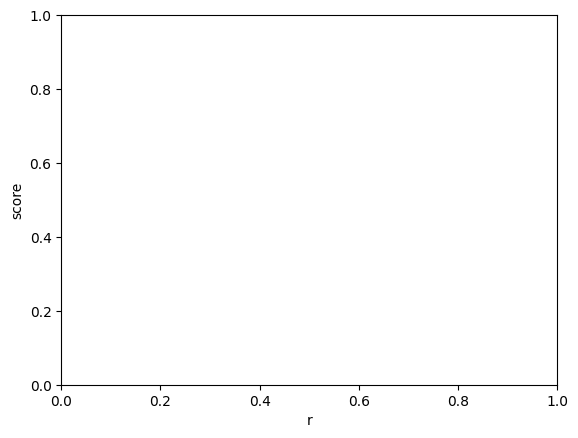

In [525]:
fig, ax = plt.subplots()
fp = [i for i in all_labels if all_labels[i] == 0]
lines = []
xs = [y[0] for y in res.result[x]['records'][150:-5]]
for x in fp:
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    lines.append((mdefs / s_mdefs, 'r'))
tp = [i for i in all_labels if all_labels[i] == 1]
for x in tp:
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    lines.append((mdefs / s_mdefs, 'b'))

import random
random.shuffle(lines)
for (ys, color) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

In [263]:
x = [2280,8055,6569,6028,4459,7567,1884,2807,4932,7845,3400,8624,7529,7305,6290,3204,2363,665,2089,8911,4650,868,4466,1507,6641,1763,468,8073,4657,2112,3488,679,873,2764,3270,2278,5003,2167,991,6483,5502,616,6787,1010,1840,5218,6801,3486,405,3485]
y = [1,1,1,1,1,0,1,0,1,0,0,0,1,1,0,1,1,0,1,1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1]
for i in range(50):
    all_labels[x[i]] = y[i]

In [264]:
len(all_labels)

214

In [278]:
for i in res.sorted_neighbors[5258, :5]:
    print(res.sorted_dist[i, :10])

[0.         0.6558764  0.65918854 0.67219497 0.68505511 0.73684211
 0.73684211 0.74968691 0.75544201 0.75544201]
[0.         0.46966991 0.55805826 0.6558764  0.67725139 0.6875
 0.6875     0.71230177 0.71693074 0.72145699]
[0.         0.50172712 0.53576165 0.54324986 0.61397568 0.61642936
 0.63948166 0.65918854 0.66574839 0.66781808]
[0.         0.59910814 0.60394098 0.61693456 0.63200996 0.64992998
 0.66666667 0.67004399 0.67219497 0.67219497]
[0.         0.46839047 0.49047533 0.49363032 0.51761809 0.52924346
 0.55447894 0.58068607 0.60776773 0.61483556]


In [284]:
res.sorted_dist[:, 100].mean() / res.sorted_dist[:, 400].mean()

0.8936536741690518

In [286]:
outlier = res.outlier_score.argsort()[-50:][::-1]


In [314]:
res.sorted_dist[2000, 200]

0.8259223440443022

In [315]:
res.sorted_dist[outlier[0], 200]

0.8675467642934955

In [313]:
(res.sorted_dist[2000] < 0.85).sum()

300

In [295]:
(res.sorted_dist[outlier[0]] < 0.85).sum()

121

In [320]:
(res.sorted_dist[:, 1:] < 0.8).sum()

1371688

In [464]:
mat_fuzzy = np.array([check_path(p) for p in paths]).astype('float')
mat_original = np.array([p['sample'] for p in paths]).astype('float')


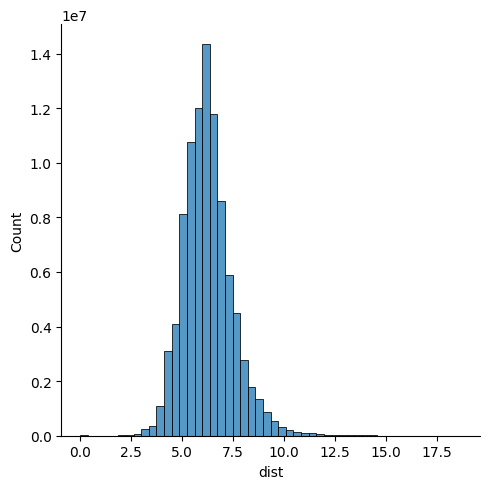

In [465]:
dist_original = pairwise_distances(X = mat_original, metric='euclidean')
import seaborn as sns
import pandas as pd
dist_original_data = pd.DataFrame({ 'dist': dist_original.reshape(-1) })
sns.displot(data=dist_original_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

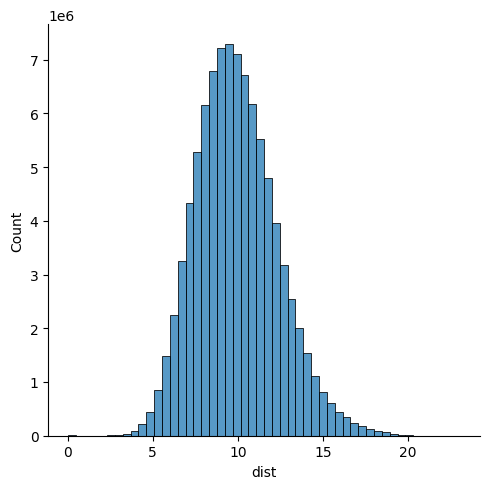

In [467]:
dist_fuzzy = pairwise_distances(X = mat_fuzzy, metric='euclidean')
import seaborn as sns
import pandas as pd
dist_fuzzy_data = pd.DataFrame({ 'dist': dist_fuzzy.reshape(-1) })
sns.displot(data=dist_fuzzy_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

In [473]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, metric='precomputed').fit_transform(dist_fuzzy)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


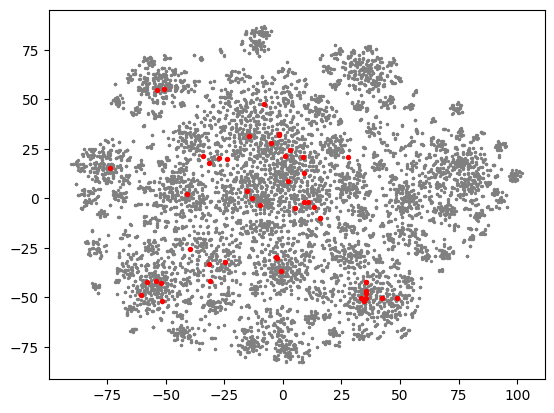

In [524]:
anomaly = res.outlier_score.argsort()[-50:][::-1]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 8, color='red')
plt.show()

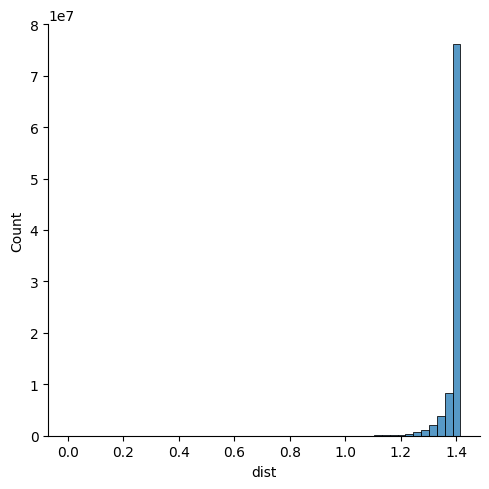

In [471]:
mat_original_n = mat_original.copy()
for i in range(mat_original_n.shape[0]):
    mat_original_n[i] /= np.sqrt(mat_original_n[i].sum())
dist_original_n = pairwise_distances(X = mat_original_n, metric='euclidean')
import seaborn as sns
import pandas as pd
dist_original_n_data = pd.DataFrame({ 'dist': dist_original_n.reshape(-1) })
sns.displot(data=dist_original_n_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

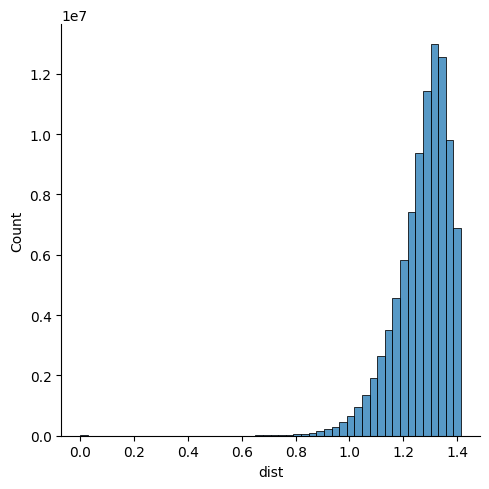

In [470]:
mat_fuzzy_normal = mat_fuzzy.copy()
for i in range(mat_fuzzy_normal.shape[0]):
    mat_fuzzy_normal[i] /= np.sqrt(mat_fuzzy_normal[i].sum())
dist_fuzzy_n = pairwise_distances(X = mat_fuzzy_normal, metric='euclidean')
import seaborn as sns
import pandas as pd
dist_fuzzy_n_data = pd.DataFrame({ 'dist': dist_fuzzy_n.reshape(-1) })
sns.displot(data=dist_fuzzy_n_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

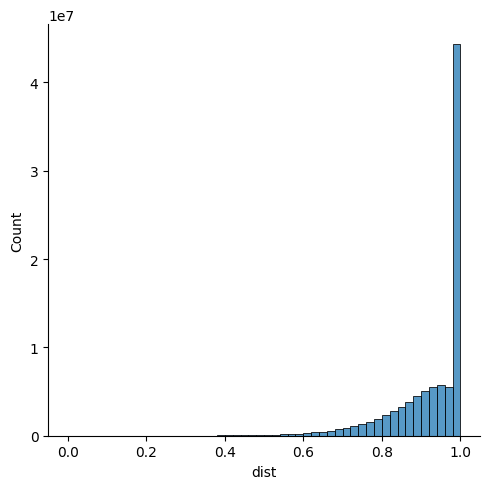

In [457]:
cos_mat = pairwise_distances(X = mat, metric='cosine')
import seaborn as sns
import pandas as pd
cos_data = pd.DataFrame({ 'dist': cos_mat.reshape(-1) })
sns.displot(data=cos_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

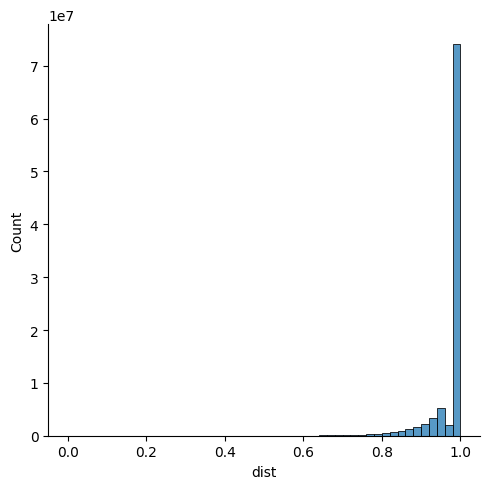

In [459]:
cos_mat2 = pairwise_distances(X = mat2, metric='cosine')
import seaborn as sns
import pandas as pd
cos_data2 = pd.DataFrame({ 'dist': cos_mat2.reshape(-1) })
sns.displot(data=cos_data2, x="dist", bins=50, log_scale=(False, False))
plt.show()